In [1]:
! pip install numba
import numba
from numba import cuda
from numba.cuda.cudadrv import enums
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from numba import vectorize

In [48]:
params = {
    'figure.figsize': [15, 10],  # instead of 4.5, 4.5
    'axes.titlesize': 15,
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'font.size': 20,
    'font.family': 'monospace',
    #    'font.monospace': 'Alma Mono',
    'legend.fontsize': 15,
    'legend.loc': 'upper right',
    'legend.labelspacing': 0.25,
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    'lines.linewidth': 3,
    'text.usetex': False,
    # 'figure.autolayout': True,
    'ytick.right': False,
    'xtick.top': False,

    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,

    'xtick.major.pad': 2,
    'ytick.major.pad': 2,
    # 'xtick.minor.pad': 14,
    # 'ytick.minor.pad': 14,

    'xtick.direction': 'inout',
    'ytick.direction': 'inout',

    'grid.linestyle': '-',         # solid
    'grid.linewidth': 1.5,        # in points
    'grid.alpha':     1,        # transparency, between 0.0 and 1.0
}
# plt.style.use('fivethirtyeight')
matplotlib.rcParams.update(params)

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [61]:
#LABWORK5 - Gaussain filter

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org_2.jpg"

# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid

@cuda.jit
def convolution(src,dst,filter,shared = False):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if shared == True:
  #Define size of running matrix
    filter_h,filter_w, = filter.shape
  else:
    # Define running matrix
    filter_h,filter_w = 7, 7
    #Shared memory
    copy_shared=cuda.shared.array(shape=(filter_h,filter_w),dtype=np.float32)
    if cuda.threadIdx.x < filter_h and cuda.threadIdx.y < filter_w:
      copy_shared[cuda.threadIdx.x, cuda.threadIdx.y] = filter[cuda.threadIdx.x, cuda.threadIdx.y]
    cuda.syncthreads()
    #cuda.syncthreads()


  for i in range(3):
    tmp_data=0
    for m in range(-(filter_h//2),(filter_h//2+1)):
      for n in range(-(filter_w//2),(filter_w//2+1)):
        if tidx + m >=0 and tidy + n >=0 and tidx + m < int(imageHeight) and tidy + n < int(imageWidth):
          if shared == False:
            tmp_data += np.float32(src[int(tidx+m),int(tidy+n),i]) * filter[m+filter_h //2, n+filter_w //2]
          else:
            tmp_data += np.float32(src[int(tidx+m),int(tidy+n),i]) * copy_shared[m+filter_h //2, n+filter_w //2]
    dst[tidx,tidy,i]=tmp_data



# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight

#Filter
Gaussian_filter=np.array([[0,0,1,2,1,0,0],[0,3,13,22,13,3,0],[1,13,59,97,59,133,1],[2,22,97,159,97,22,2] \
                            ,[1,13,59,97,59,13,1],[0,3,13,22,13,3,0],[0,0,1,2,1,0,0]],dtype=np.float32) / 1003

#Ouput image
gauss_img = np.array(img_data, copy=True)

def compare(blockSize,output=False,shared=False):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)

  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_data)

  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)

  convolution[gridSize,blockSize](devSrc, devDst,Gaussian_filter,shared)
  cuda.synchronize()

  #Copy from device to host
  hostDst = devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if output == True:
    return run_time, hostDst
  else:
    return run_time

67 120
The run time is 0.022156953811645508 s


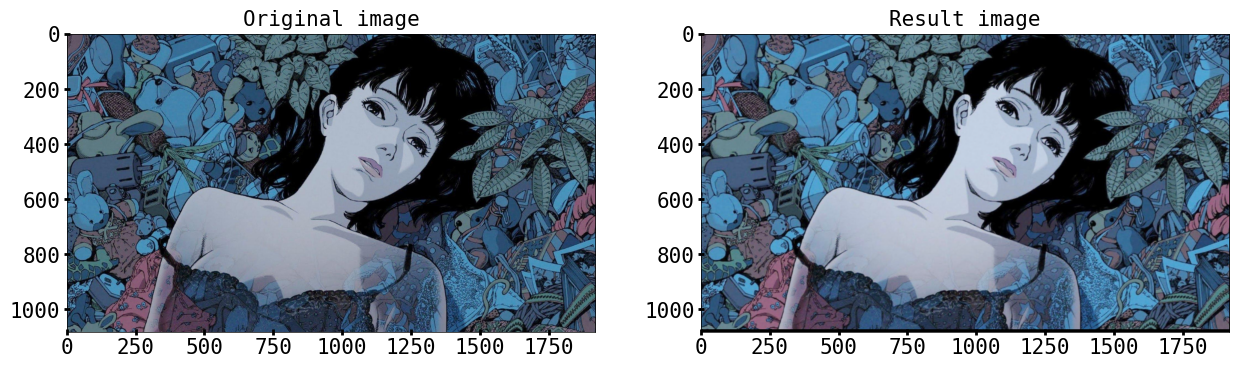

In [73]:
#Output run_time and hostDst

plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img_data)

plt.subplot(1,2,2)
blockSize = 16
run_time,hostDst= compare(blockSize,output=True)

# Show the resule image
plt.title("Result image")
plt.imshow(hostDst)

# Save the image
plt.savefig(Data_path+"Test_result_LW5.jpg")
print("The run time is",run_time,"s")

1082 1920


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


The runtime for the blockSize 1 is 0.33930301666259766
541 960
The runtime for the blockSize 2 is 0.051689863204956055
270 480
The runtime for the blockSize 4 is 0.01759958267211914
135 240
The runtime for the blockSize 8 is 0.011548519134521484
67 120
The runtime for the blockSize 16 is 0.011529207229614258


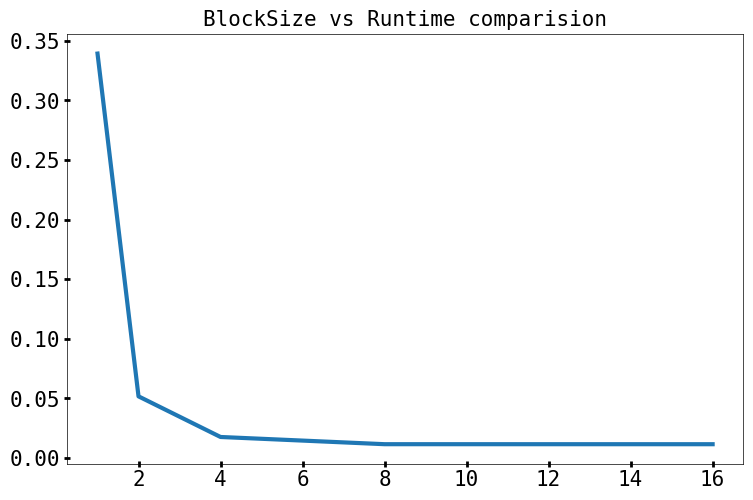

In [74]:
plt.subplot(2,2,1)
### Comparision
runtime_list=[]
blockSize_final=[]
for i in range(5):
  blockSize=2**i
  run_time=compare(blockSize,output=False)
  runtime_list.append(run_time)
  blockSize_final.append(blockSize)
  print(f"The runtime for the blockSize {blockSize} is {run_time}")

  name=f'L5 - BlockSize vs Runtime comparision' # - Shared memory')
plt.plot(blockSize_final,runtime_list)
plt.title("BlockSize vs Runtime comparision") #- Shared memory")
plt.savefig(Data_path + name + ",png")


plt.tight_layout()
plt.show()